In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
import re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

## Data Understanding

In [45]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df_sample_submit = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [46]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [47]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [48]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [50]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [51]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [52]:
df_train['target'].value_counts()/len(df_train['target'])*100

target
0    57.034021
1    42.965979
Name: count, dtype: float64

## Data Preparation

As Evaluation metric F1 score will be used, because the same metric will be used by the host of the competition


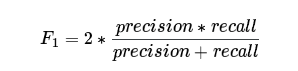

Where 

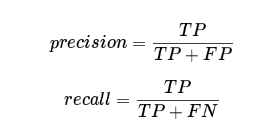

In [53]:
## Firstly i will make light preprocess of the data and then compare words ditribution for preprocessed and original text 
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

# Check how it will influence different ML models
def process_light(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
class Preprocess_data:
    def __init__(self, df, text_column):
        self.df = df
        self.text_column = text_column
    
    def add_num_words(self):
        self.df['num_words'] = self.df[self.text_column].apply(lambda x: len(x.split()))
        
    def add_num_unique_columns(self):
        self.df['num_unqiue_words'] = self.df[self.text_column].apply(lambda x: len(set(x.split())))
        
    def add_num_symbols(self):
        self.df['num_symbols'] = self.df[self.text_column].apply(len)
    
    def add_num_sent(self):
        self.df['num_sent'] = self.df[self.text_column].apply(lambda x: len(x.split('.')))
    
    def fit(self, df, text_column):
        self.df = df
        self.text_column = text_column
        
    def fill_na(self):
        self.df['keyword'] = self.df['keyword'].fillna("empty keyword")
        self.df['location'] = self.df['location'].fillna("empty location")
        
    def add_columns(self):
        self.add_num_words()
        self.add_num_unique_columns()
        self.add_num_symbols()
        self.add_num_sent()
        self.fill_na()
        return self.df

In [55]:
df_light_preprocess = df_train.copy()
df_light_preprocess['text'] = df_train['text'].map(process_light)

prep_data = Preprocess_data(df_light_preprocess, "text")
df_light_preprocess = prep_data.add_columns()

prep_data.fit(df_train, "text")
df_train = prep_data.add_columns()

## EDA

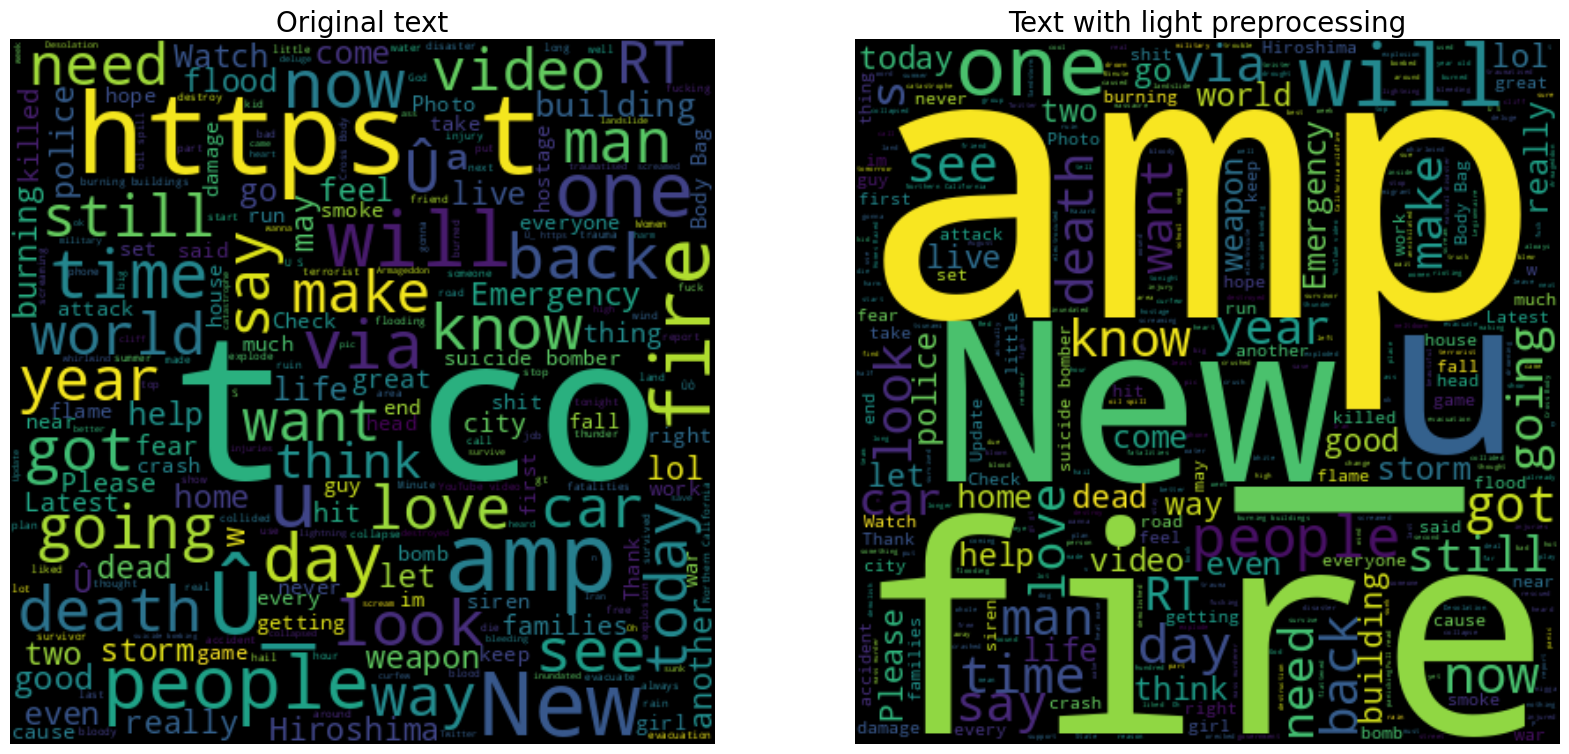

In [56]:
figure, axes = plt.subplots(1,2,figsize = (20,20))

wc = WordCloud(max_words = 500, width = 400, height = 400 ).generate(" ".join(df_train['text']))
axes[0].imshow(wc, interpolation = "bilinear")
axes[0].set_title("Original text", fontsize = 20)
axes[0].set_axis_off()

wc = WordCloud(max_words = 500, width = 400, height = 400 ).generate(" ".join(df_light_preprocess['text']))
axes[1].imshow(wc, interpolation = "bilinear")
axes[1].set_title("Text with light preprocessing", fontsize = 20)
axes[1].set_axis_off()

We can make conlusion that after preprocessing some unnecessary words has been removed from the text, and words which is associated with disasters has increased influnce in the text

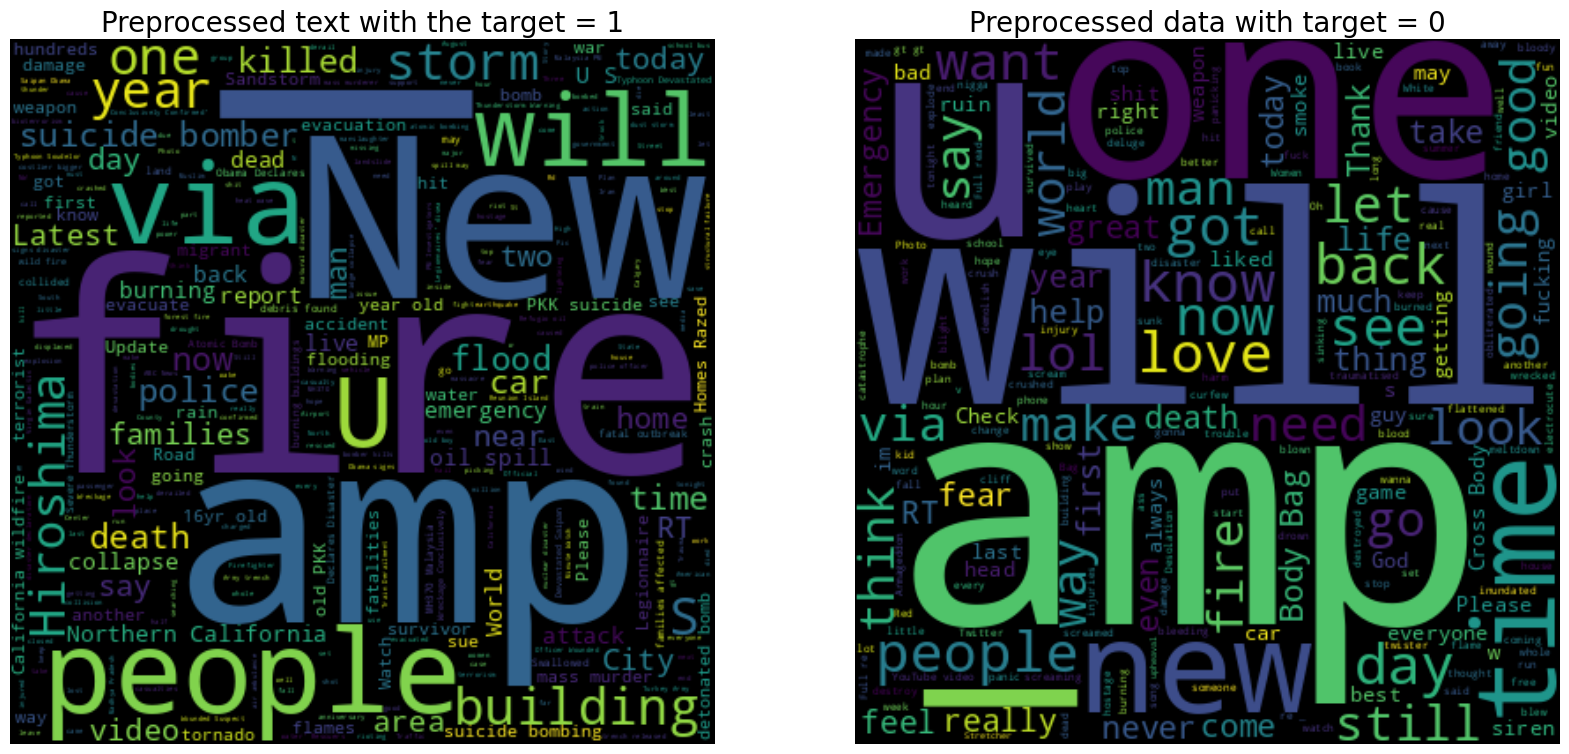

In [57]:
figure, axes = plt.subplots(1,2, figsize = (20,20))

filter_1 = df_light_preprocess['target'] == 1
wc = WordCloud(max_words = 500, width = 400, height = 400 ).generate(" ".join(df_light_preprocess[filter_1]['text']))
axes[0].imshow(wc, interpolation = "bilinear")
axes[0].set_title("Preprocessed text with the target = 1", fontsize = 20)
axes[0].set_axis_off()

filter_0 = df_light_preprocess['target'] == 0
wc = WordCloud(max_words = 500, width = 400, height = 400 ).generate(" ".join(df_light_preprocess[filter_0]['text']))
axes[1].imshow(wc, interpolation = "bilinear")
axes[1].set_title("Preprocessed data with target = 0", fontsize = 20)
axes[1].set_axis_off()

For both categories we have word "amp" in the list of the most common words among each target category. Next step will be to see the distrbution of number of words, sentences and number of unique words for the target value

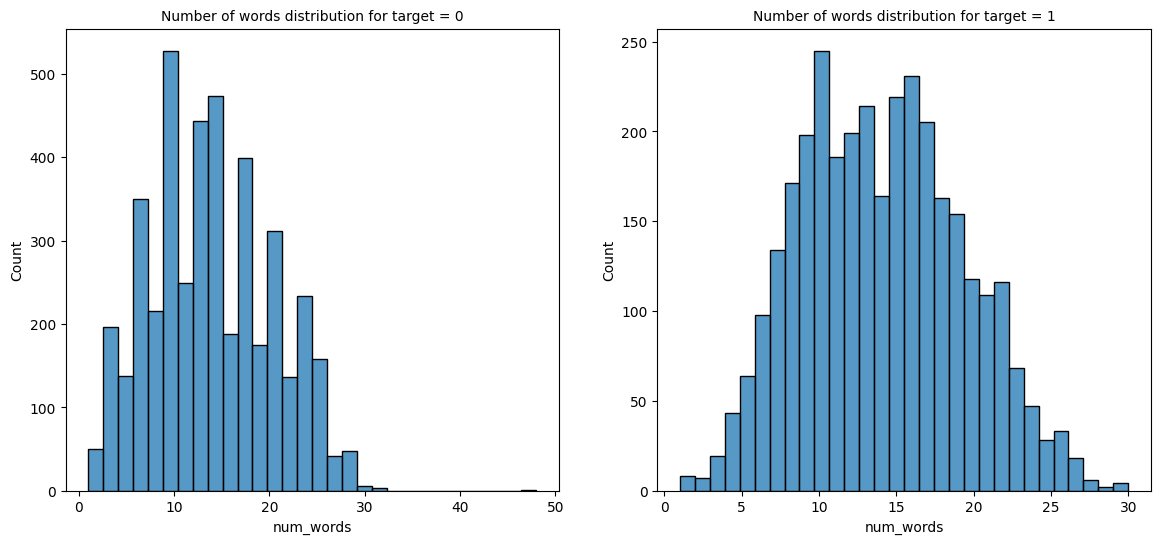

In [58]:
figure, axes = plt.subplots(1,2,figsize = (14,6))

sns.histplot(df_light_preprocess[filter_0]['num_words'], ax = axes[0], bins = 30)
axes[0].set_title("Number of words distribution for target = 0",fontsize = 10)

sns.histplot(df_light_preprocess[filter_1]['num_words'], ax = axes[1], bins = 30)
axes[1].set_title("Number of words distribution for target = 1",fontsize = 10)
plt.show()

We can observe that target 0 we can easily observe outliers in the data as in the target 1 texts, moreover comparing to the texts with target 0 target 1 has not so many words

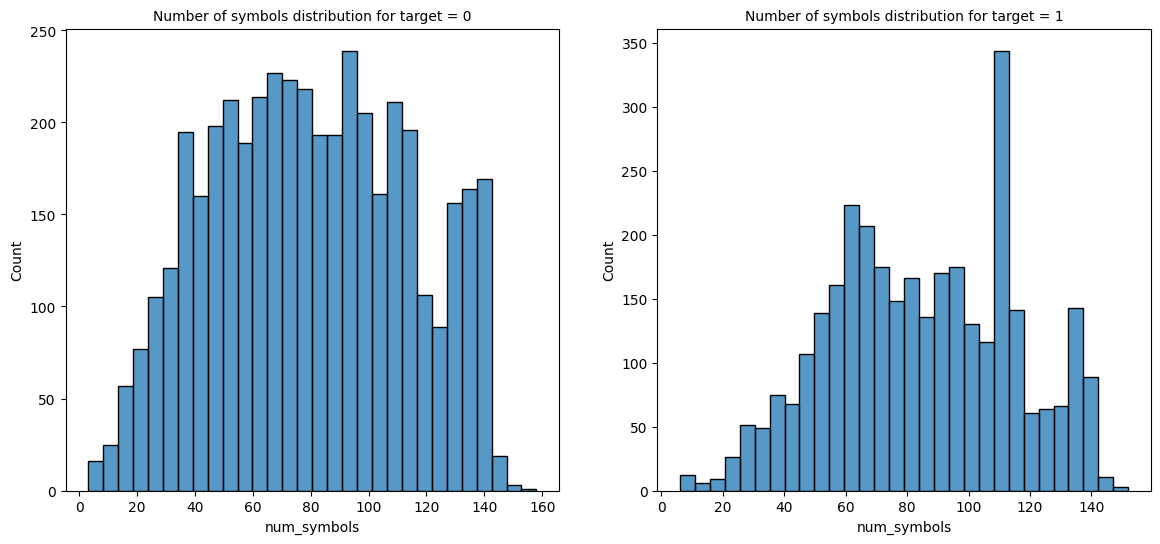

In [59]:
figure, axes = plt.subplots(1,2,figsize = (14,6))

sns.histplot(df_light_preprocess[filter_0]['num_symbols'], ax = axes[0], bins = 30)
axes[0].set_title("Number of symbols distribution for target = 0",fontsize = 10)

sns.histplot(df_light_preprocess[filter_1]['num_symbols'], ax = axes[1], bins = 30)
axes[1].set_title("Number of symbols distribution for target = 1",fontsize = 10)
plt.show()

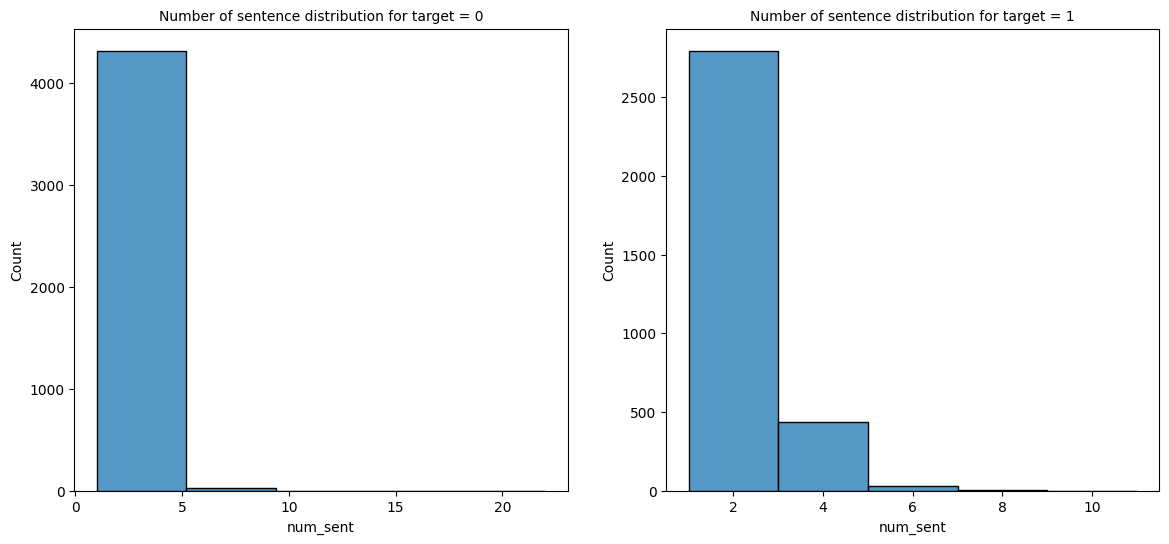

In [60]:
figure, axes = plt.subplots(1,2,figsize = (14,6))

sns.histplot(df_light_preprocess[filter_0]['num_sent'], ax = axes[0], bins = 5)
axes[0].set_title("Number of sentence distribution for target = 0",fontsize = 10)

sns.histplot(df_light_preprocess[filter_1]['num_sent'], ax = axes[1], bins = 5)
axes[1].set_title("Number of sentence distribution for target = 1",fontsize = 10)
plt.show()

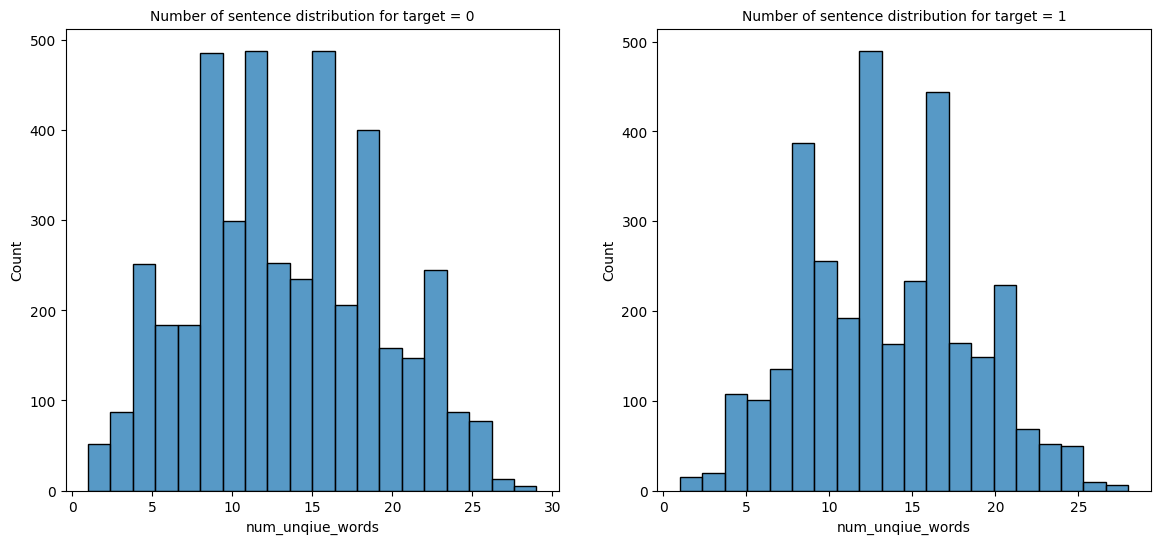

In [61]:
figure, axes = plt.subplots(1,2,figsize = (14,6))

sns.histplot(df_light_preprocess[filter_0]['num_unqiue_words'], ax = axes[0], bins = 20)
axes[0].set_title("Number of sentence distribution for target = 0",fontsize = 10)

sns.histplot(df_light_preprocess[filter_1]['num_unqiue_words'], ax = axes[1], bins = 20)
axes[1].set_title("Number of sentence distribution for target = 1",fontsize = 10)
plt.show()

## Modeling

In [62]:
df_light_preprocess

,id,keyword,location,text,target,num_words,num_unqiue_words,num_symbols,num_sent
0,1,empty keyword,empty location,Our Deeds are the Reason of this May ALLAH Fo...,1,12,12,58,1
1,4,empty keyword,empty location,Forest fire near La Ronge Sask. Canada,1,7,7,38,2
2,5,empty keyword,empty location,All residents asked to 'shelter in place' are ...,1,22,20,133,2
3,6,empty keyword,empty location,"13,000 people receive evacuation orders in Ca...",1,7,7,54,1
4,7,empty keyword,empty location,Just got sent this photo from Ruby as smoke f...,1,14,13,70,1
...,...,...,...,...,...,...,...,...,...
7608,10869,empty keyword,empty location,Two giant cranes holding a bridge collapse int...,1,10,10,60,1
7609,10870,empty keyword,empty location,@aria_ahrary @TheTawniest The out of control w...,1,20,17,125,3
7610,10871,empty keyword,empty location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1,7,7,42,3
7611,10872,empty keyword,empty location,Police investigating after an e-bike collided ...,1,19,19,137,3


In [63]:
df_light_preprocess['merged_text'] = df_light_preprocess['text'] + " " + df_light_preprocess['keyword'] + " " + df_light_preprocess['location']

## Testing different Validation Techniques

First of all I will try to split my dataset into training and validation and see the result

In [64]:
features_to_select = ["merged_text", "num_words", "num_unqiue_words", "num_symbols", "num_sent"]
X = df_light_preprocess[features_to_select]
y = df_light_preprocess['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [65]:
#Vectorization of the text 
def vectorize_text_col(df, text_col, vectorizer):
    res = vectorizer.transform(df[text_col])
    df = df.drop(text_col,axis = 1)
    new_df = pd.concat([df.reset_index(drop = True), pd.DataFrame(res.toarray(), columns = vectorizer.get_feature_names_out())], axis = 1, join = "outer")
    return new_df

vectorizer = TfidfVectorizer(analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000)
vectorizer.fit(X_train["merged_text"])

X_train = vectorize_text_col(X_train, "merged_text", vectorizer)
X_test = vectorize_text_col(X_test, "merged_text", vectorizer)

In [66]:
#models
log_model = LogisticRegression(max_iter = 1000)
nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print(f"F1 score for Naive Bayes Classifier {f1_score(nb_pred, y_test, average = 'macro')}")

log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
print(f"F1 score for Logistic regression {f1_score(log_pred, y_test, average = 'macro')}")



F1 score for Naive Bayes Classifier 0.74824614857405
F1 score for Logistic regression 0.7662775833387201


Let's predict test results and compare this result with LB score

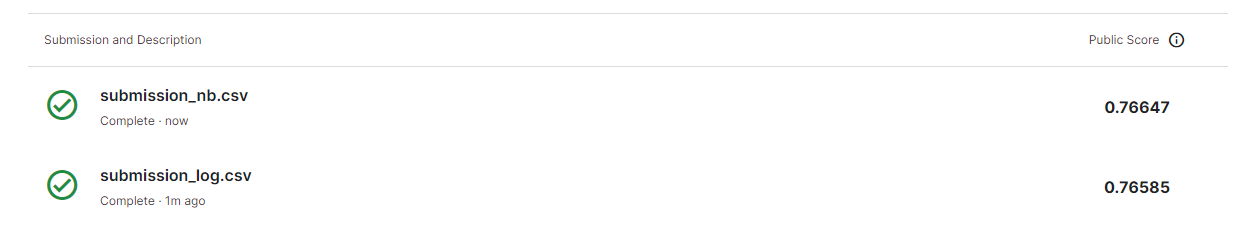

Have obtained the result that F1 score for both of the models have higher value than in the notebook validation but, in notebook validation Naive Bayes Classifier has lower accuracy than Logistic Regression, but in the submission Naive Bayes accuracy is a little bit higher than Logistic Regression accuracy. However this is bad situation because we don't have increase correlation. Let's try on the simple K-Fold Cross Validation

In [67]:
prep_data = Preprocess_data(df_test, "text")
df_test = prep_data.add_columns()
df_test['merged_text'] = df_test['text'] + " " + df_test['keyword'] + " " + df_test['location']
df_test = df_test[features_to_select]
df_test['merged_text'] = df_test['merged_text'].map(process_light)
df_test_1 = vectorize_text_col(df_test, 'merged_text', vectorizer)

/tmp/ipykernel_32/2636741204.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['merged_text'] = df_test['merged_text'].map(process_light)


In [68]:
df_submit_log = df_sample_submit.copy()
df_submit_nb = df_sample_submit.copy()

df_submit_log['target'] = log_model.predict(df_test_1)
df_submit_nb['target'] = nb_model.predict(df_test_1)

df_submit_log.to_csv('submission_log.csv', index=False)
df_submit_nb.to_csv('submission_nb.csv', index=False)

In [69]:
def check_val_score(stratified = False):
    df_kfold = df_light_preprocess[features_to_select].copy()
    y = df_light_preprocess['target']
    vectorizer_kfold = TfidfVectorizer(analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=5,
            max_features=30000)

    vectorizer_kfold = vectorizer.fit(df_kfold['merged_text'])
    df_kfold = vectorize_text_col(df_kfold, "merged_text", vectorizer_kfold)
    
    if not stratified:
        cv = KFold(n_splits = 7, shuffle = True, random_state = 42)
    else:
        cv = StratifiedKFold(n_splits = 7, shuffle = True, random_state = 42)
        
    models = {"Logistic Regression":LogisticRegression(max_iter = 1000),
              "Naive Bayes Classifier": MultinomialNB()}

    results = []
    model_pred = []
    for model_name, model in models.items():
        scores = []
        for train_ind, test_ind in cv.split(df_kfold, y):
            X_train, X_test = df_kfold.iloc[train_ind], df_kfold.iloc[test_ind]
            y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

            model.fit(X_train, y_train)
            prediction = model.predict(X_test)

            scores.append(f1_score(prediction, y_test, average = "macro"))

        scores = np.array(scores)
        avg_score = round(np.mean(scores), 4)
        min_score = round(np.min(scores), 4)
        max_score = round(np.max(scores), 4)
        std_score = round(np.std(scores), 4)
        score_lower_bound = round(avg_score - 3 * std_score, 4)
        score_higher_bound = round(avg_score + 3 * std_score, 4)

        results.append({"Model": model_name,
                       "Avegare Score": avg_score,
                       "Minimal Score":min_score,
                       "Maximal Score":max_score,
                       "Standard Deviation":std_score,
                       "Lower bound estimation": score_lower_bound,
                       "Higher bound estimation": score_higher_bound})
        df_test_kfold = vectorize_text_col(df_test, 'merged_text', vectorizer_kfold)
        df_sub = df_sample_submit.copy()
        df_sub['target'] = model.predict(df_test_kfold)
        if stratified:
            df_sub.to_csv(f"Submissions_{model_name}_StratifiedKFold.csv", index=False)
        else:
            df_sub.to_csv(f"Submissions_{model_name}_KFold.csv", index=False)
    results = pd.DataFrame(results)
    return results

In [70]:
check_val_score()

,Model,Avegare Score,Minimal Score,Maximal Score,Standard Deviation,Lower bound estimation,Higher bound estimation
0,Logistic Regression,0.7814,0.7700,0.8026,0.0119,0.7457,0.8171
1,Naive Bayes Classifier,0.7621,0.7397,0.7926,0.0188,0.7057,0.8185


So I have received next result for this new models 
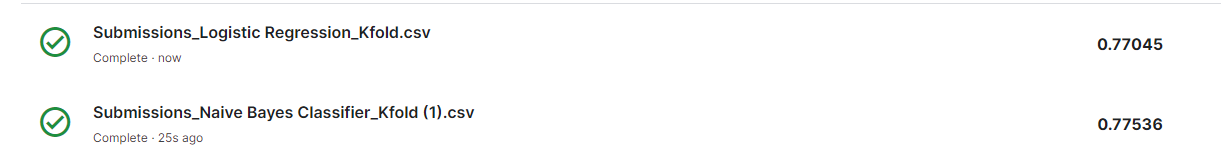

In this case we have similar situation to the submitting results based on the one validation set,but for logistic regression score is closer to to the minimal score. However for Naive Bayes classifier result obtained form the LB is closer to the maximal score. On the next step I will try stratified KFold

In [71]:
check_val_score(stratified = True)

,Model,Avegare Score,Minimal Score,Maximal Score,Standard Deviation,Lower bound estimation,Higher bound estimation
0,Logistic Regression,0.7792,0.7570,0.7933,0.0112,0.7456,0.8128
1,Naive Bayes Classifier,0.7626,0.7351,0.7792,0.0133,0.7227,0.8025


With models trained on Stratified KFold, next results have been obtained

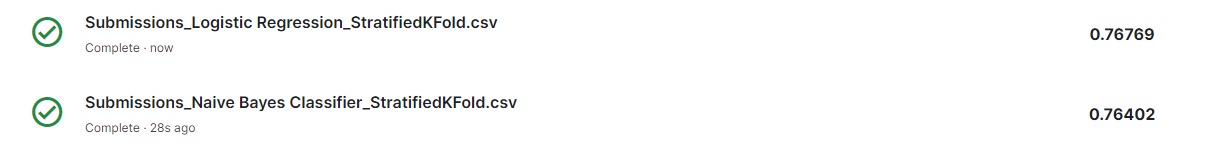

In this case metrics for both of models has reduced closer to submission of the first validation. And here we finally can observe correlation between metrics increase, so Stratified KFold fot this moment is the best validation technique which can be used for validation models in this project. I want to add about metris obtained during Strtified KFold we can see that average F1 score for Logisitic Regression has reduced compared to the previously obtained results. And finally for simple KFold and for Stratified KFold we can observe that F1-score on the LB is in range of lower bound estimation and higher bound estimation

## Adversarial validation 

Now i will perform the adversarial validation  for understanding if test data is from the same distribution as train data or not

In [72]:
def find_adversarial_validation(X_adval_train, X_adval_test, y_adval_train ,y_adval_test):
    adval_vectorizer = TfidfVectorizer(analyzer='word',
            stop_words='english',
            ngram_range=(1, 3),
            lowercase=True,
            min_df=5,
            max_features=30000)

    adval_vectorizer.fit(X_adval_train['merged_text'])
    X_adval_train = vectorize_text_col(X_adval_train, 'merged_text', adval_vectorizer)
    X_adval_test = vectorize_text_col(X_adval_test, 'merged_text', adval_vectorizer)

    ad_val = LogisticRegression(max_iter = 1000)
    ad_val.fit(X_adval_train ,y_adval_train)
    ad_val_pred = ad_val.predict_proba(X_adval_test)
    roc_auc = roc_auc_score(y_adval_test, ad_val_pred[:,1])
    return roc_auc, ad_val.coef_.T, X_adval_train.columns
    
df_light_preprocess.loc[:,'train_df'] = 1
df_test.loc[:,'train_df'] = 0
df_for_ad_val = pd.concat([df_light_preprocess.drop(['id', 'keyword', 'location', 'text', 'target'], axis = 1), df_test],axis = 0, join = "outer")

X_adval_train, X_adval_test, y_adval_train ,y_adval_test = train_test_split(df_for_ad_val[features_to_select], df_for_ad_val['train_df'], test_size = 0.33,random_state = 42)
roc_auc, coef, features = find_adversarial_validation(X_adval_train, X_adval_test, y_adval_train ,y_adval_test)
print(f"ROC AUC for adverisal validation {roc_auc}")

/tmp/ipykernel_32/1614345319.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,'train_df'] = 0


ROC AUC for adverisal validation 0.7919062892204713


So we have high value of AUC ROC score which identifies that we have significant feature distribution shift, it can examine that test set and train set comes from other distribution. One of the reason of this shift can be the split of the data from hosts of the project to test your model on different distribution, moreover in the test. As we can see below, some of words are identified more with test dataset than with train, it can be as a result of changing tendency in the disasters all around the world

In [73]:
imp_score = pd.DataFrame(index = features, data = coef,columns = ["Importance score"]).sort_values(by="Importance score")
words_to_remove = np.array(imp_score[imp_score['Importance score']<0].index)
imp_score[imp_score['Importance score']<-1]

,Importance score
smoke,-1.709038
blew,-1.621123
try,-1.610784
tell,-1.574898
ll,-1.571590
drown,-1.555092
need,-1.540971
room,-1.473094
sirens,-1.393755
trying,-1.357733


So there are words that have the biggest influence in the model, so this words can be frequently found in the test set but not in the train set.